@ Jungang(Gordon) Chen,
Texas A&M University  
jungangc@tamu.edu

### Step 1. Load libaraies and config hardware (gpu)

In [1]:
import numpy as np
import h5py
import torch
import torch.nn as nn
from datetime import datetime

from MSE2C import MSE2C
from MSloss import CustomizedLoss
from ROMWithMSE2C import ROMWithE2C

# from pcc_model import PCC
from data_preprocessing import *

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
import timeit

<Figure size 640x480 with 0 Axes>

In [2]:
print(torch.__version__)

2.0.0+cu117


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
output_dir = './saved_models/'

data_dir = 'data/'
state_file = 'states_norm_slt'
ctrl_file = 'controls_norm_slt'
yobs_file = 'rate_norm_slt'

state_data = state_file + '.mat'
ctrl_data = ctrl_file + '.mat'
yobs_data = yobs_file + '.mat'

In [5]:
nsteps = 2
Mole_slt, SAT_slt, PRES_slt, BHP_slt, Yobs_slt, num_t_slt, Nx, Ny, num_well, num_prod, num_inj = prepare_data(nsteps, data_dir, state_data, ctrl_data, yobs_data)

(600, 21, 64, 64)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [6]:
n_channels = 3
STATE_train, BHP_train, Yobs_train, STATE_eval, BHP_eval, Yobs_eval =train_split_data(Mole_slt, SAT_slt, PRES_slt, BHP_slt, Yobs_slt, num_t_slt, Nx, Ny, num_well, num_prod, num_inj, n_channels, device)

In [7]:
num_train = STATE_train[0].shape[0]
num_eval = STATE_eval[0].shape[0]

In [8]:
dt_train = torch.tensor(np.ones((num_train,1)), dtype=torch.float32).to(device) # dt=20days, normalized to 1
dt_eval = torch.tensor(np.ones((num_eval, 1)), dtype=torch.float32).to(device) # dt=20days, normalized to 1

## Step 2. Specify params and filenames

In [9]:
method = 'E2C'
ode_steps = 0

In [10]:
#################### model specification ##################
epoch = 200
batch_size = 4
learning_rate = 2e-4
latent_dim = 20

u_dim = num_well  # control dimension, gaussian 9 wells

In [11]:
input_shape = (n_channels, Nx, Ny)
perm_shape = (1, Nx, Ny)
prod_loc_shape = (num_well, 2)

In [12]:
encoder_file = output_dir + 'e2co_encoder_dt_'+'_nt%d_l%d_lr%.0e_ep%d_steps%d_channels%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, n_channels)
decoder_file = output_dir + 'e2co_decoder_dt_'+'_nt%d_l%d_lr%.0e_ep%d_steps%d_channels%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, n_channels)
transition_file = output_dir + 'e2co_transition_dt_' +'_nt%d_l%d_lr%.0e_ep%d_steps%d_channels%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, n_channels)

print("encoder_file:", encoder_file)
print("decoder_file:", decoder_file)
print("transition_file:", transition_file)

encoder_file: ./saved_models/e2co_encoder_dt__nt9000_l20_lr2e-04_ep200_steps2_channels3.h5
decoder_file: ./saved_models/e2co_decoder_dt__nt9000_l20_lr2e-04_ep200_steps2_channels3.h5
transition_file: ./saved_models/e2co_transition_dt__nt9000_l20_lr2e-04_ep200_steps2_channels3.h5


In [13]:
my_rom = ROMWithE2C(latent_dim, 
                    u_dim, num_prod, num_inj, 
                    input_shape, 
                    perm_shape, 
                    prod_loc_shape, 
                    learning_rate,
                    method, 
                    ode_steps,
                    nsteps, 
                    sigma=0.0).to(device)

# Section 1: E2C Training

## Load state data

In [14]:
num_batch = int(num_train/batch_size)
print("num_batch: ", num_batch)

num_batch:  2250


In [15]:
# perm = scio.loadmat('data/TRUE_PERM_64by220.mat')
# m_full = torch.tensor(perm['TRUE_PERM'],dtype=torch.float32).to(device)
# m = 10**m_full[:Nx, 120:Ny+120]
# m = m.reshape(1, 64, 64)
# print('m shape is ', m.shape)
# plt.imshow(m.detach().cpu().numpy().squeeze())

# # m_eval = np.repeat(np.expand_dims(m, axis = 0), state_t_eval.shape[0], axis = 0)
# m_eval = torch.unsqueeze(m, axis = 0).repeat(STATE_eval[0].shape[0], 1,1,1)
# print("m_eval shape is ", m_eval.shape)

# # m = np.repeat(np.expand_dims(m,axis = 0), state_t_train.shape[0], axis = 0)
# m_train = torch.unsqueeze(m, axis = 0).repeat(STATE_train[0].shape[0], 1,1,1)
# print("m shape is ", m.shape)

In [16]:
# well_loc_file = data_dir + 'template/well_loc00.dat'

# well_loc = torch.tensor(np.loadtxt(well_loc_file), dtype=torch.int32).to(device)
# num_prod = well_loc[0,0]
# num_inj = well_loc[0,1]
# num_well = num_prod+num_inj
# print(num_inj, num_prod)

# prod_loc = well_loc[1:num_prod+1,:]
# print("prod_loc:\n{}".format(prod_loc))
# print(prod_loc.shape)

# print('prod_loc shape is ', prod_loc.shape)
# # prod_loc_tf = tf.placeholder(tf.int32, shape=(num_prod,2))


In [17]:
# ## used to generate log directory
# currentDT = datetime.now()
# current_time = str(currentDT).replace(" ", "-")[:-10]
# print(current_time)
# summary_writer = tf.summary.create_file_writer('logs/' + case_name + case_suffix + '_ep' + str(epoch) + '_tr' + str(n_train_run) + '_' + current_time)

# @tf.function
def write_summary(value, tag, writer, global_step):
    with writer.as_default():
        tf.summary.scalar(tag, value, step=global_step)

## Start training process

In [18]:
best_loss = 1.0e9
# with tf.device(device):
for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        
        X_batch  = [state[ind0:ind0+batch_size, ...] for state in STATE_train]
        U_batch = [bhp[ind0:ind0 + batch_size, ...] for bhp in BHP_train]
        Y_batch = [yobs[ind0:ind0 + batch_size, ...] for yobs in Yobs_train]
        # m_batch  = m[ind0:ind0 + batch_size, ...].permute(0,3,1,2)
        dt_batch  = dt_train[ind0:ind0 + batch_size, ...]
        
        inputs = (X_batch, U_batch, Y_batch, dt_batch)
        # labels = state_t1_batch

        my_rom.update(inputs)

        n_itr = e * num_train + ib * batch_size + batch_size
#             write_summary(my_rom.train_loss.result(), 'train/total_loss', summary_writer, n_itr) # log for tensorboard
#             write_summary(my_rom.train_reconstruction_loss.result(), 'train/reconstruction_loss', summary_writer, n_itr) # log for tensorboard
#             write_summary(my_rom.train_flux_loss.result(), 'train/flux_loss', summary_writer, n_itr) # log for tensorboard
#             write_summary(my_rom.train_well_loss.result(), 'train/well_loss', summary_writer, n_itr) # log for tensorboard
#             summary_writer.flush()

        if ib % 300 == 0:
#             print('Epoch %d/%d, Batch %d/%d, Loss %f,' % (e+1, epoch, ib+1, num_batch, my_rom.train_loss.result()))
            print('Epoch %d/%d, Batch %d/%d, Loss %f,' % (e+1, epoch, ib+1, num_batch, my_rom.train_loss))
            X_batch_eval = [state for state in STATE_eval]
            U_batch_eval = [bhp for bhp in BHP_eval]
            Y_batch_eval = [yobs for yobs in Yobs_eval]
            test_inputs = (X_batch_eval, U_batch_eval, Y_batch_eval, dt_eval)
            # test_labels = state_t1_eval.permute(0,3,1,2)
            my_rom.evaluate(test_inputs)

#                 write_summary(my_rom.test_loss.result(), 'eval/total_loss', summary_writer, n_itr) # log for tensorboard
#                 summary_writer.flush()

    print('====================================================')
    print('Epoch %d/%d, Train loss %f, Eval loss %f' % (e + 1, epoch, my_rom.train_loss, my_rom.test_loss))
    print('====================================================')
    
    ## Save best model parameters to file
    if my_rom.test_loss < best_loss:    
        my_rom.model.save_weights_to_file(encoder_file, decoder_file, transition_file)
        best_loss = my_rom.test_loss

Epoch 1/200, Batch 1/2250, Loss 80201.195312,
Epoch 1/200, Batch 301/2250, Loss 1774.085815,
Epoch 1/200, Batch 601/2250, Loss 1303.425659,
Epoch 1/200, Batch 901/2250, Loss 694.514221,
Epoch 1/200, Batch 1201/2250, Loss 657.830994,
Epoch 1/200, Batch 1501/2250, Loss 589.567627,
Epoch 1/200, Batch 1801/2250, Loss 656.153320,
Epoch 1/200, Batch 2101/2250, Loss 536.524963,
Epoch 1/200, Train loss 475.657501, Eval loss 471.967682
Epoch 2/200, Batch 1/2250, Loss 419.859253,
Epoch 2/200, Batch 301/2250, Loss 483.983826,
Epoch 2/200, Batch 601/2250, Loss 550.616516,
Epoch 2/200, Batch 901/2250, Loss 354.842804,
Epoch 2/200, Batch 1201/2250, Loss 315.612976,
Epoch 2/200, Batch 1501/2250, Loss 329.953583,
Epoch 2/200, Batch 1801/2250, Loss 343.114441,
Epoch 2/200, Batch 2101/2250, Loss 320.659454,
Epoch 2/200, Train loss 363.542297, Eval loss 273.380859
Epoch 3/200, Batch 1/2250, Loss 290.498932,
Epoch 3/200, Batch 301/2250, Loss 328.369141,
Epoch 3/200, Batch 601/2250, Loss 355.724091,
Epoch 

# Seciton 2: E2C Test (Eval)

## Load ROM with E2C model (if you did not run section 1)

In [19]:
my_rom.model.load_weights_from_file(encoder_file, decoder_file, transition_file)

## Load and manipulate data

In [20]:
hf_r = h5py.File(data_dir + state_data, 'r')
mole = torch.tensor(np.array(hf_r.get('Mole_frac_norm_slt')).transpose((3,2,1,0)) , dtype=torch.float32)
sat = torch.tensor(np.array(hf_r.get('Sg_norm_slt')).transpose((3,2,1,0)) , dtype=torch.float32)
pres = torch.tensor(np.array(hf_r.get('Psim_norm_slt')).transpose((3,2,1,0)) , dtype=torch.float32)
hf_r.close()

In [21]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = torch.tensor(np.array(hf_r.get('Pwf_norm_slt')).transpose((2,1,0)) , dtype=torch.float32)
rate0 = torch.tensor(np.array(hf_r.get('Qinj_norm_slt')).transpose((2,1,0)) , dtype=torch.float32)
hf_r.close()

In [22]:
bhp = torch.cat((bhp0,rate0),dim=1)
print(bhp.shape)

torch.Size([600, 9, 20])


In [23]:
hf_r = h5py.File(data_dir + yobs_data)
Qrate_w = torch.tensor(np.array(hf_r.get('Qpro_w_RC_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
Qrate_g = torch.tensor(np.array(hf_r.get('Qpro_g_RC_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
BHP_inj = torch.tensor(np.array(hf_r.get('BHPinj_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
hf_r.close()
yobs = torch.cat((Qrate_w,Qrate_g,BHP_inj),dim=1)

In [24]:
# test_case0 = torch.tensor(np.zeros((25,4)), dtype=torch.float32)
# a = torch.tensor(np.array(range(75,400,100))[np.newaxis,:], dtype=torch.float32)
# b = torch.tensor(np.array(range(25))[:,np.newaxis], dtype=torch.float32)

# test_case = (test_case0 + a + b).T.reshape(100)
# test_case = torch.tensor(np.array(test_case).astype(int), dtype=torch.float32)

test_case0 = np.zeros((25,4))
a = np.array(range(75,400,100))[np.newaxis,:]
b = np.array(range(25))[:,np.newaxis]

test_case = (test_case0 + a + b).T.reshape(100)
test_case = np.array(test_case).astype(int)

## Pick 4 representative test cases to visualize  
Note here we have 100 test cases. In the E2C sequential workflow, prediction are done for all of them. However, to keep the notebook clean and short, we will only visualize a subset of 100.

In [25]:
ind_case = np.array([10, 25, 77, 97])

In [26]:
num_case = test_case.shape[0] # 4
num_tstep = 20

mole_pred = torch.tensor(np.zeros((num_case, num_tstep, 1 , Nx, Ny)), dtype=torch.float32).to(device) 
sat_pred = torch.tensor(np.zeros((num_case, num_tstep, 1 , Nx, Ny)), dtype=torch.float32).to(device) 
pres_pred = torch.tensor(np.zeros((num_case, num_tstep, 1, Nx, Ny)), dtype=torch.float32).to(device) 
yobs_pred = torch.tensor(np.zeros((num_case, num_tstep, num_prod*2+num_inj)), dtype=torch.float32).to(device) 

num_prod = 5
num_inj = 4
num_well = num_prod + num_inj

num_all_case = 400
num_ctrl = 20

Specify timesteps, time intervals, etc.

## Reshape the input data  
To a proper format, so that it can be easily consumed by E2C model

In [27]:
t_steps = np.arange(0,200,200//num_tstep)

dt = 10
t_steps1 = (t_steps + dt).astype(int)

indt_del = t_steps1 - t_steps
indt_del = indt_del / max(indt_del)

tmp = np.array(range(num_tstep)) - 1
tmp1 = np.array(range(num_tstep))
tmp[0] = 0

In [28]:
tmp1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [29]:
# bhp_b0 = bhp.reshape(num_all_case, num_well, num_ctrl)
# # bhp_b1 = np.repeat(bhp_b0[..., np.newaxis], num_tstep // num_ctrl, axis=3)
# bhp_b1 = bhp_b0.unsqueeze(-1).repeat(1, 1, 1, num_tstep // num_ctrl)
# assert num_tstep // num_ctrl * num_ctrl == num_tstep, "no exaxt division num_step = %d, num_ctrl=%d"%(num_tstep, num_ctrl)

# bhp_b2 = bhp_b1.reshape(num_all_case, num_well, num_tstep)

# bhp_tt = bhp_b0[:,:, tmp]
bhp_tt1 = bhp[:,:, tmp1]

# bhp_tt0 = torch.cat((bhp_tt, bhp_tt1), dim=1)
bhp_t = torch.swapaxes(bhp_tt1,1,2).to(device)

bhp_seq = bhp_t[test_case, :, :]

In [30]:
mole_t_seq = mole[test_case, 0:1, ...].to(device)
sat_t_seq = sat[test_case, 0:1, ...].to(device)
pres_t_seq = pres[test_case, 0:1, ...].to(device)

state_t_seq = torch.cat((mole_t_seq, sat_t_seq, pres_t_seq),dim=1)
state_pred = torch.cat((mole_pred, sat_pred, pres_pred),dim=2)

In [31]:
yobs_t_seq = torch.swapaxes(yobs[test_case,...],1,2).to(device)

In [32]:
# m_t_seq = np.repeat(np.expand_dims(m, axis = 0), state_t_seq.shape[0], axis = 0)

In [33]:
# prod_loc_t_seq = np.repeat(np.expand_dims(prod_loc, axis = 0), state_t_seq.shape[0], axis = 0)

In [34]:
# m_t_seq = m.unsqueeze(0).repeat(state_t_seq.shape[0], 1, 1, 1)

In [35]:
# prod_loc_t_seq = prod_loc.unsqueeze(0).repeat(state_t_seq.shape[0], 1, 1)

## E2C sequential workflow

In [36]:
state_t_seq.shape

torch.Size([100, 3, 64, 64])

In [37]:
start = timeit.default_timer()

for i_tstep in range(num_tstep):
#     state_pred[:, i_tstep, ...] = state_t_seq.clone()
    state_pred[:, i_tstep, ...] = state_t_seq
    dt_seq = torch.tensor(np.ones((num_case,1)) * indt_del[i_tstep], dtype=torch.float32).to(device) 
    inputs = (state_t_seq, bhp_seq[:,i_tstep,:], yobs_t_seq[:,i_tstep,:],dt_seq)
    state_t1_seq, yobs_t1_seq = my_rom.predict(inputs)
#     state_t_seq = state_t1_seq.clone()
    state_t_seq = state_t1_seq
    yobs_pred[:,i_tstep,:] = yobs_t1_seq

end = timeit.default_timer()
print("Time for sequential process: %f" %(end - start))

Time for sequential process: 2.995028


## Visualization

In [38]:
mole_seq_true = mole[test_case, ...]

# sat_seq_true = sat[test_case[ind_case], ...]
sat_seq_true = sat[test_case, ...]
sat_seq_true = sat_seq_true

# pres_seq_true = pres[test_case[ind_case], ...]
pres_seq_true = pres[test_case, ...]
pres_seq_true = pres_seq_true
state_seq_true = torch.zeros((len(test_case),n_channels,21,Nx,Ny))
state_seq_true[:,0,:,:] = mole_seq_true
state_seq_true[:,1,:,:] = sat_seq_true
state_seq_true[:,2,:,:] = pres_seq_true

In [39]:
yobs_seq_true =  torch.swapaxes(yobs[test_case,...],1,2)

### Visualization for mole fraction

In [40]:
mole_max = 1.0
mole_min = 0.0
mole_diff = mole_max - mole_min
mole_pred_plot = state_pred[:, :, 0, :, :] * mole_diff + mole_min
state_pred[:, :, 0, :, :] = state_pred[:, :, 0, :, :] * mole_diff + mole_min

Case num: 10


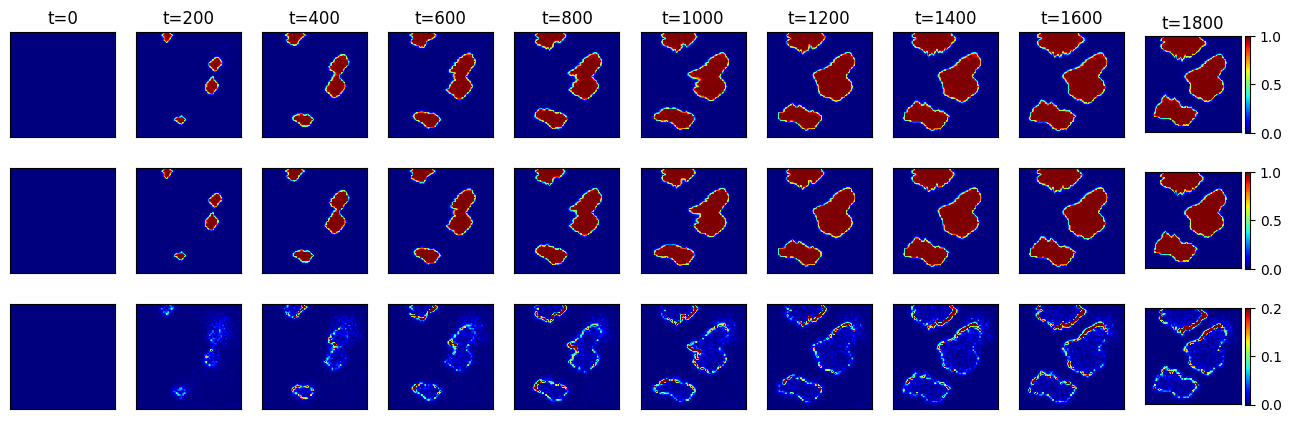

Case num: 25


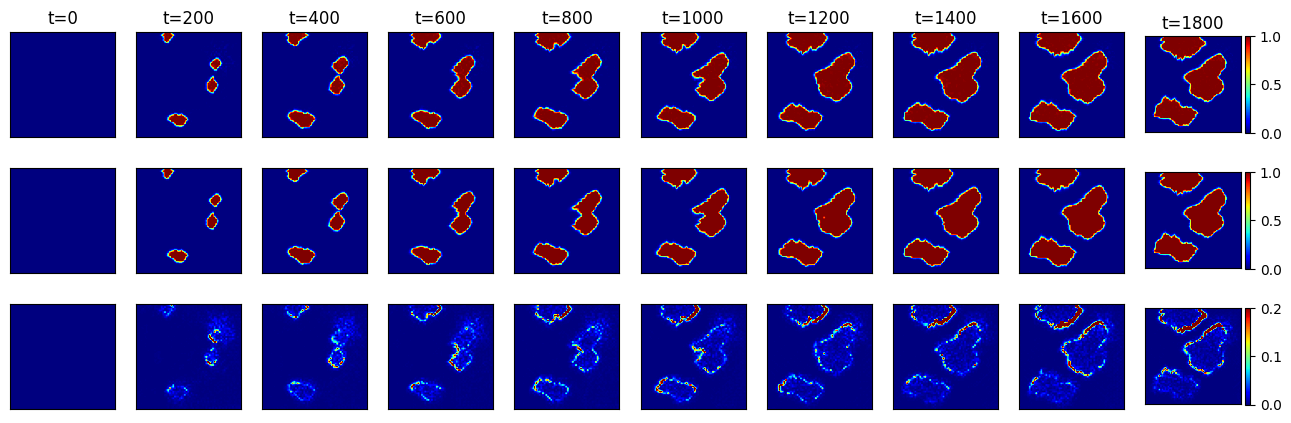

Case num: 77


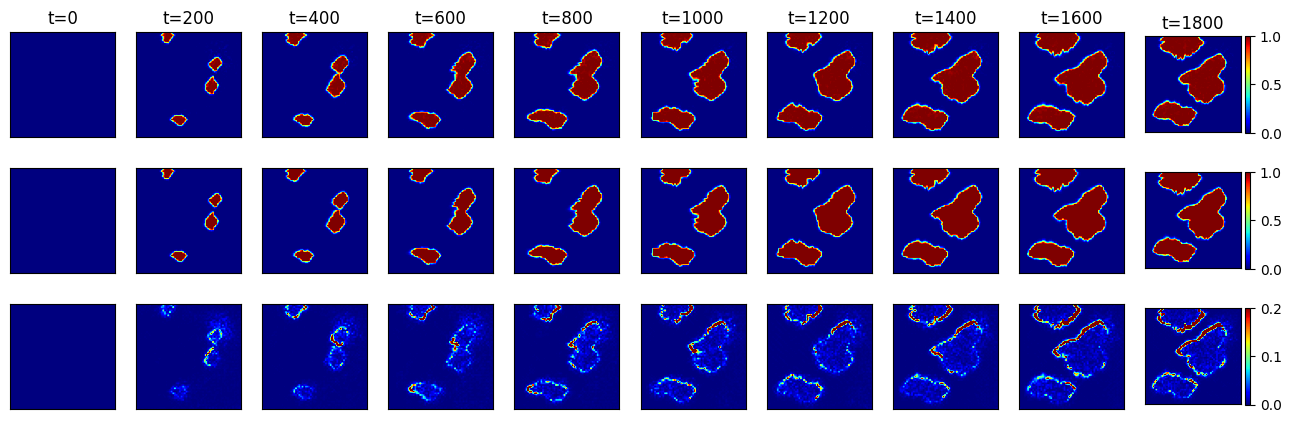

Case num: 97


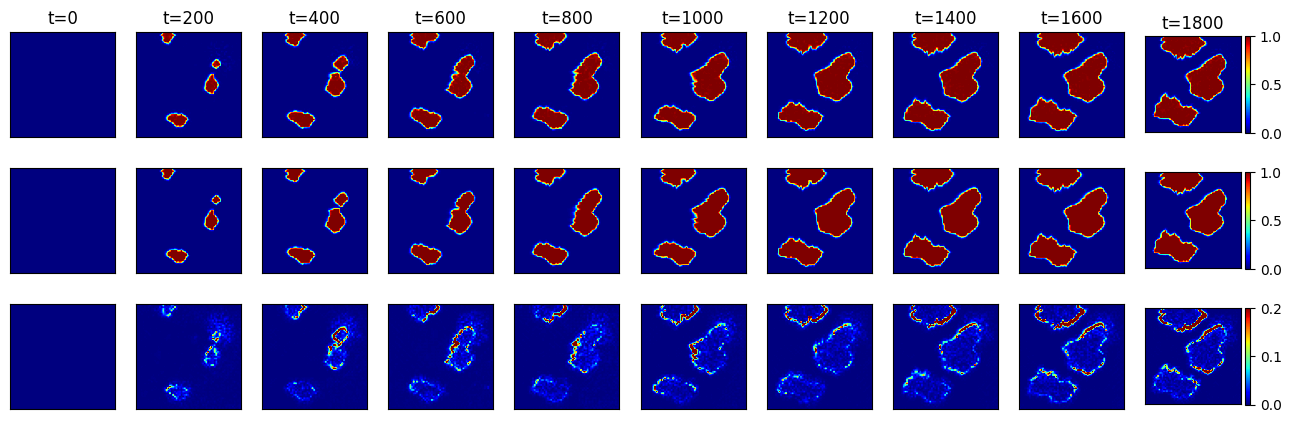

In [41]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(mole_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy())
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.0, 1.0])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046, pad=0.04) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true[ind_case[k], 0, i_tstep*divide, :])
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.0, 1.0])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046, pad=0.04)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(torch.abs(state_seq_true[ind_case[k], 0, i_tstep*divide, ...] - mole_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy()))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.20])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046, pad=0.04) 

    plt.show()

### Visualization for saturation

In [42]:
s_max = 1.0
s_min = 0.0
s_diff = s_max - s_min

In [43]:
sat_pred_plot = state_pred[:, :, 1, :, :] * s_diff + s_min
state_pred[:, :, 1, :, :] = state_pred[:, :, 1, :, :] * s_diff + s_min

In [44]:
# divide = 2
# for k in range(4):
#     print("Case num: %d"%ind_case[k])
#     plt.figure(figsize=(16,5))
#     for i_tstep in range(len(t_steps)//divide):
#         plt.subplot(3, num_tstep//divide, i_tstep+1)
#         plt.imshow(sat_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy())
#         plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
#         plt.xticks([])
#         plt.yticks([])
#         plt.clim([0.1, 0.7])
#         if i_tstep == 9:
#             plt.colorbar(fraction=0.046) 

Case num: 10


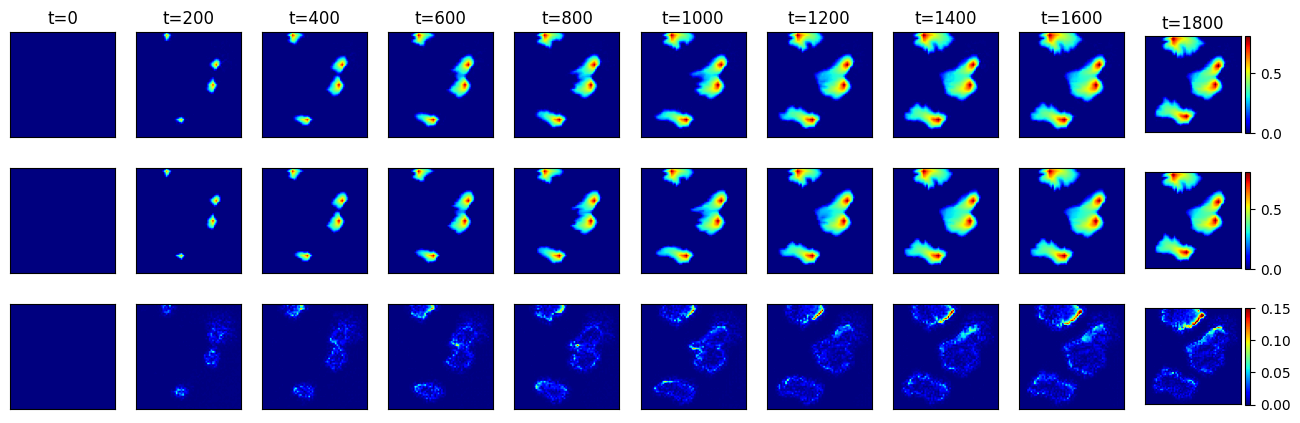

Case num: 25


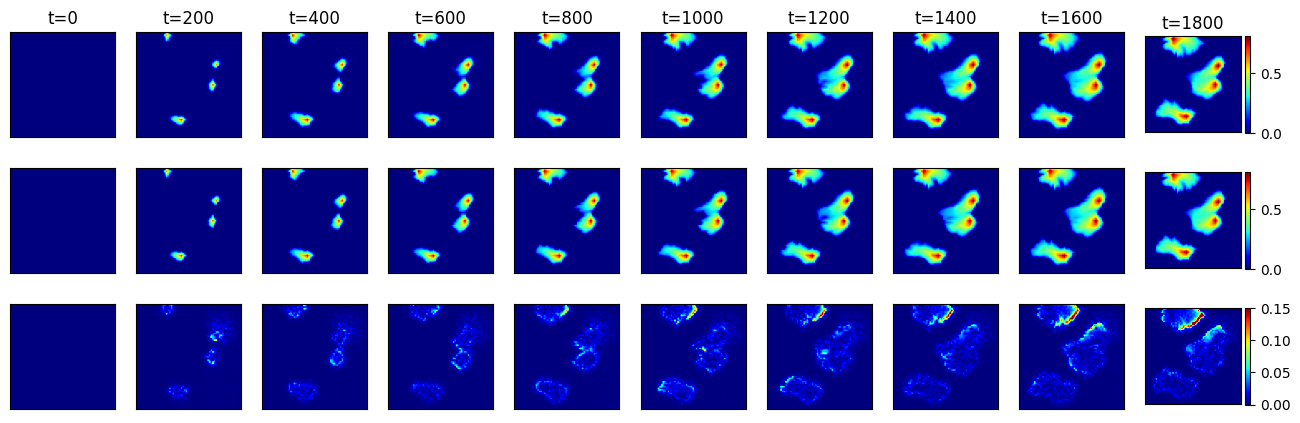

Case num: 77


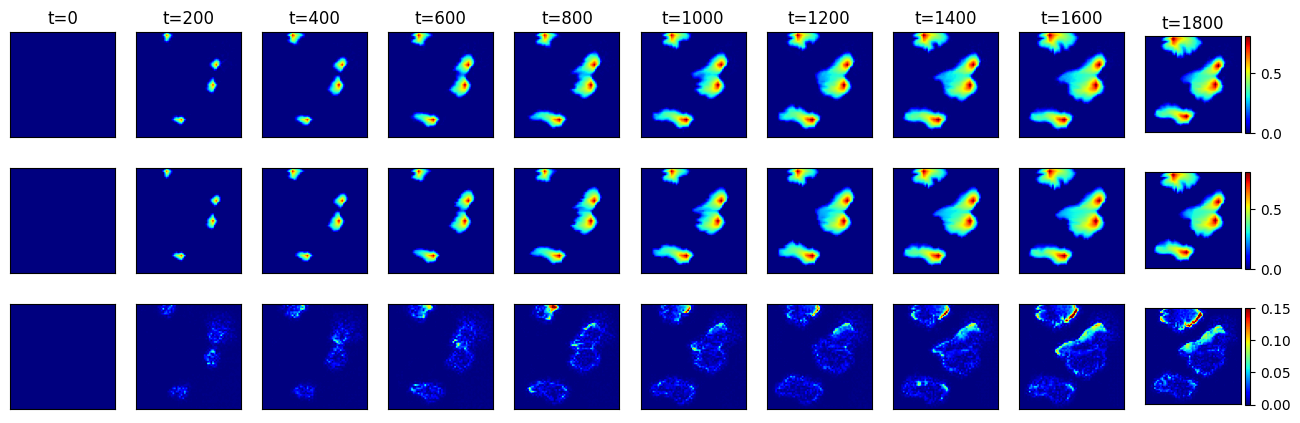

Case num: 97


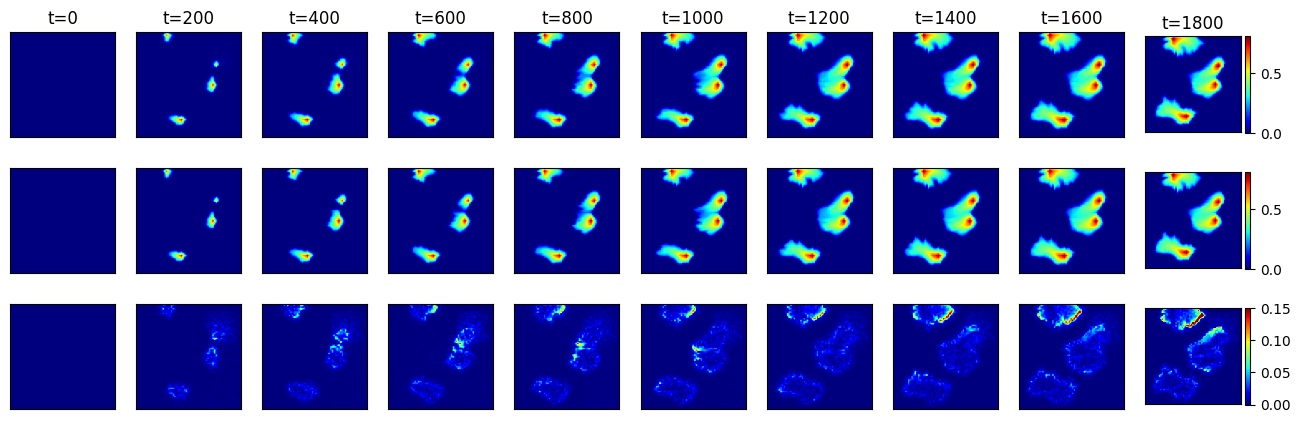

In [45]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(sat_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy())
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.0, 0.81])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046, pad=0.04) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true[ind_case[k], 1, i_tstep*divide, :])
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.0, 0.81])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046, pad=0.04)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(torch.abs(state_seq_true[ind_case[k], 1, i_tstep*divide, ...] - sat_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy()))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046, pad=0.04) 

    plt.show()

In [46]:
# from sklearn.metrics import mean_absolute_percentage_error
# divide = 1
# mape_sat = np.zeros(len(t_steps))
# plt.figure(figsize=(16,5))
# LEGENDS= [] 
# for k in range(len(test_case)):
#     # print("Case num: %d"%ind_case[k])
#     for i_tstep in range(len(t_steps)//divide):
#         # plt.subplot(1, num_tstep//divide, i_tstep+1)
#         mape_sat[i_tstep] = mean_absolute_percentage_error(state_seq_true[k, 0, i_tstep*divide, :], sat_pred_plot[k, i_tstep*divide, :,:].cpu().detach().numpy())
    
#     plt.plot(mape_sat)
#     # LEGENDS.append("Case num: {}".format(ind_case[k]))

# # plt.legend(LEGENDS)
# plt.show()

### Visualization for pressure

In [47]:
p_max = 4069.2
p_min = 2200
p_diff = p_max - p_min

In [48]:
state_pred_plot = state_pred[:, :, 2, :, :] * p_diff + p_min
state_seq_true_plot = state_seq_true[:, 2, :, :] * p_diff + p_min

Case num: 10


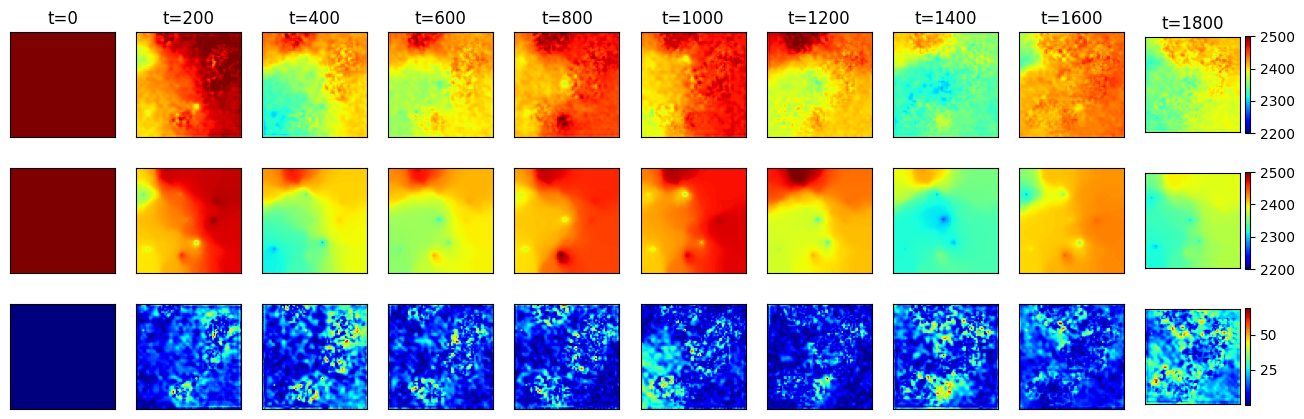

Case num: 25


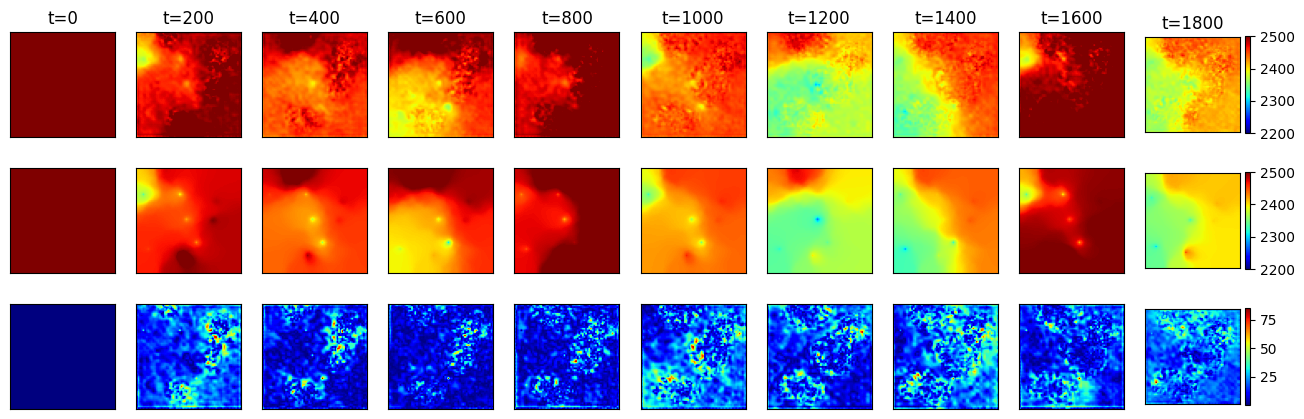

Case num: 77


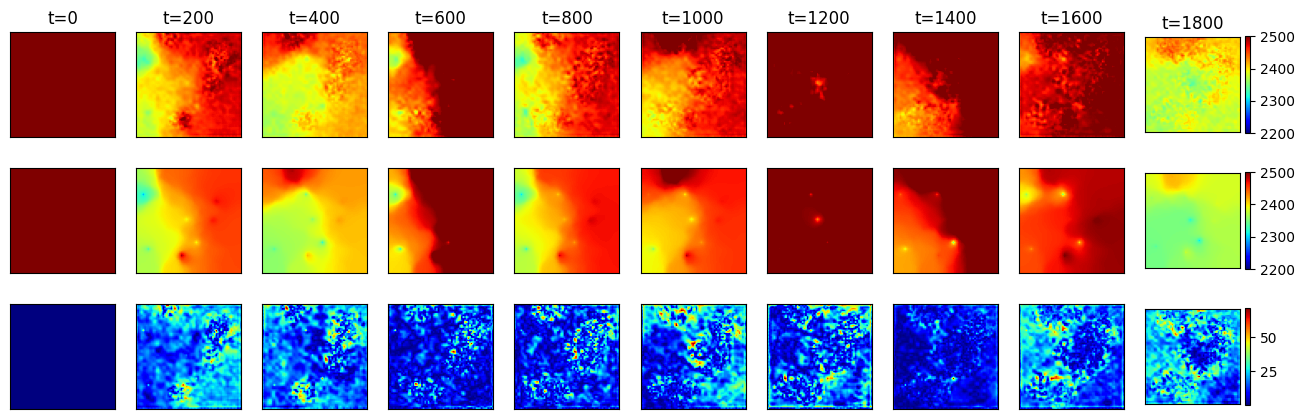

Case num: 97


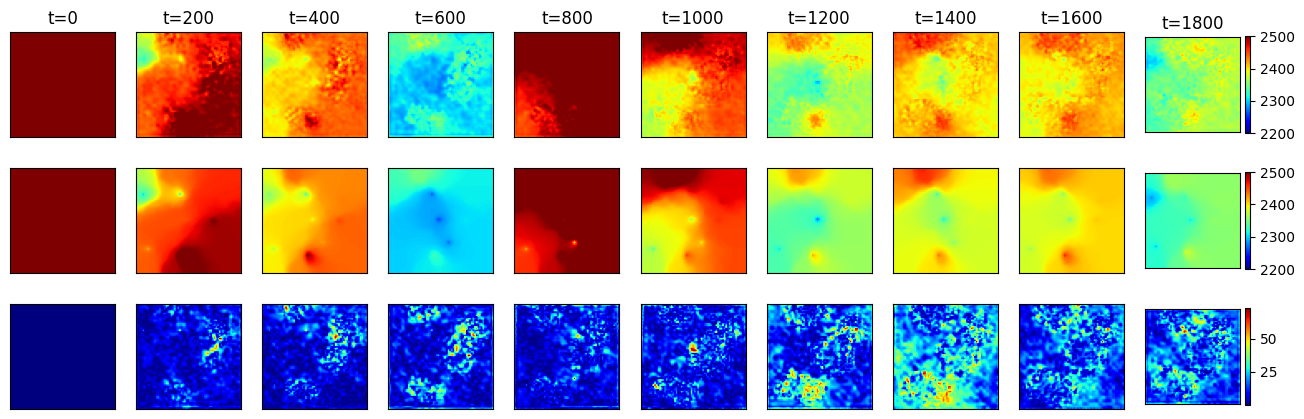

In [49]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(state_pred_plot[ind_case[k], i_tstep*divide, :, :].cpu().detach().numpy())
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
        plt.clim([2200, 2500])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true_plot[ind_case[k], i_tstep*divide, ...])
        plt.xticks([])
        plt.yticks([])
        plt.clim([2200, 2500])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(np.fabs(state_seq_true_plot[ind_case[k], i_tstep*divide, ...] - state_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy()))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([0, 0.02])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

In [50]:
# divide = 1
# mape_pres = np.zeros(len(t_steps))
# plt.figure(figsize=(16,5))
# LEGENDS= [] 
# for k in range(len(test_case)):
#     # print("Case num: %d"%ind_case[k])
#     for i_tstep in range(len(t_steps)//divide):
#         # plt.subplot(1, num_tstep//divide, i_tstep+1)
#         mape_pres[i_tstep] = mean_absolute_percentage_error(state_seq_true_plot[k, i_tstep*divide, :], state_pred_plot[k, i_tstep*divide, :, :].cpu().detach().numpy())
    
#     plt.plot(mape_pres)
#     # LEGENDS.append("Case num: {}".format(ind_case[k]))

# # plt.legend(LEGENDS)
# plt.show()

### Visualization for observations

In [51]:
Q_min = 0
Q_max = 2381.9
Q_diff = Q_max - Q_min

In [52]:
yobs_pred[:,:,:2*num_prod] = yobs_pred[:,:,:2*num_prod]*Q_diff+Q_min
yobs_seq_true[:,:,:2*num_prod] = yobs_seq_true[:,:,:2*num_prod]*Q_diff+Q_min
yobs_pred[:,:,2*num_prod:] = yobs_pred[:,:,2*num_prod:]*p_diff+p_min
yobs_seq_true[:,:,2*num_prod:] = yobs_seq_true[:,:,2*num_prod:]*p_diff+p_min

In [53]:
yobs_pred.shape

torch.Size([100, 20, 14])

In [54]:
yobs_seq_true.shape

torch.Size([100, 20, 14])

Well num: 0


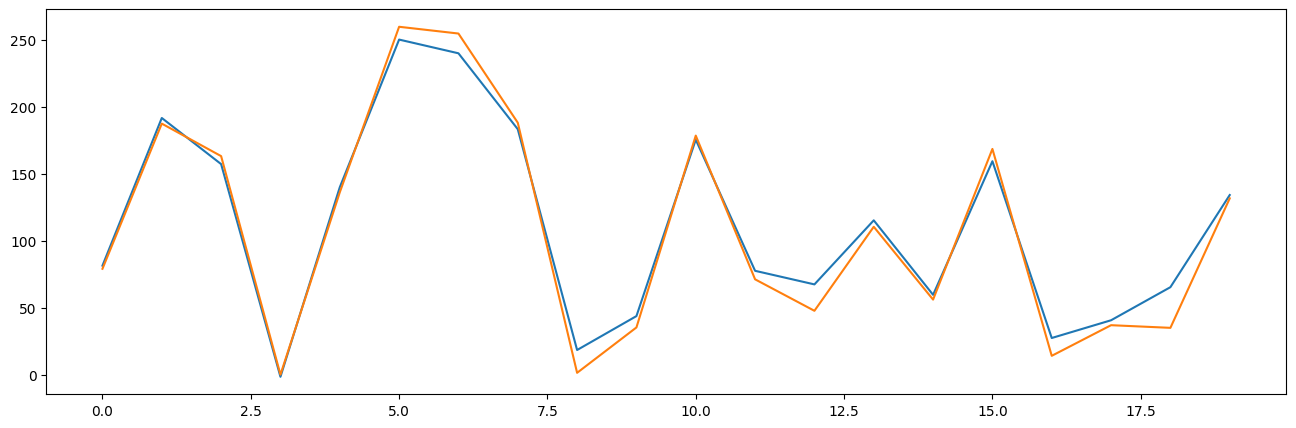

Well num: 1


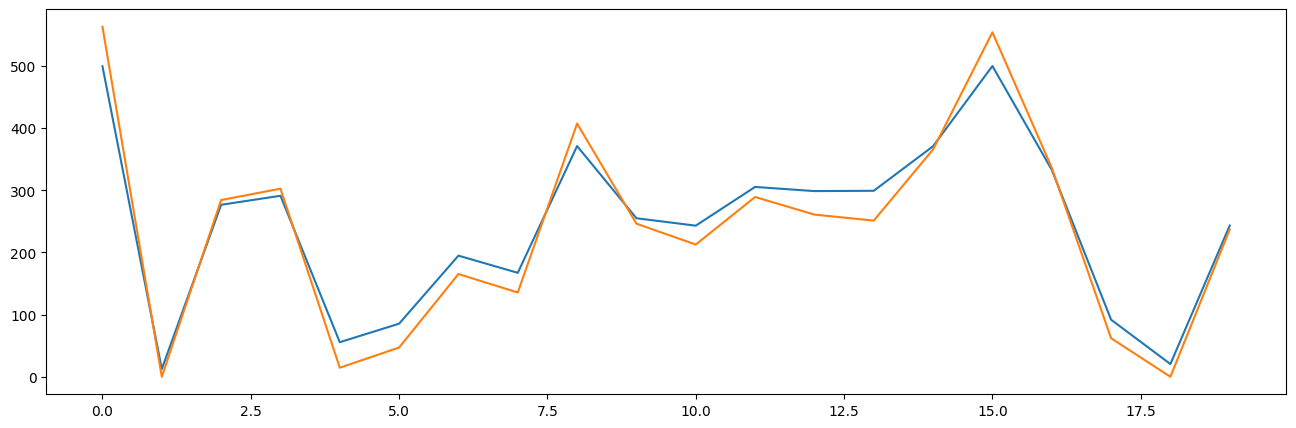

Well num: 2


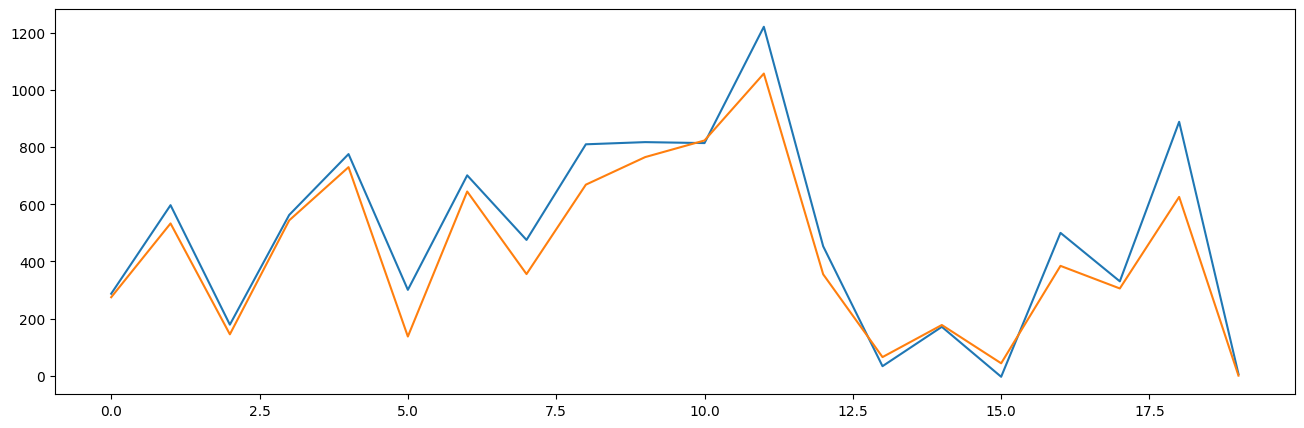

Well num: 3


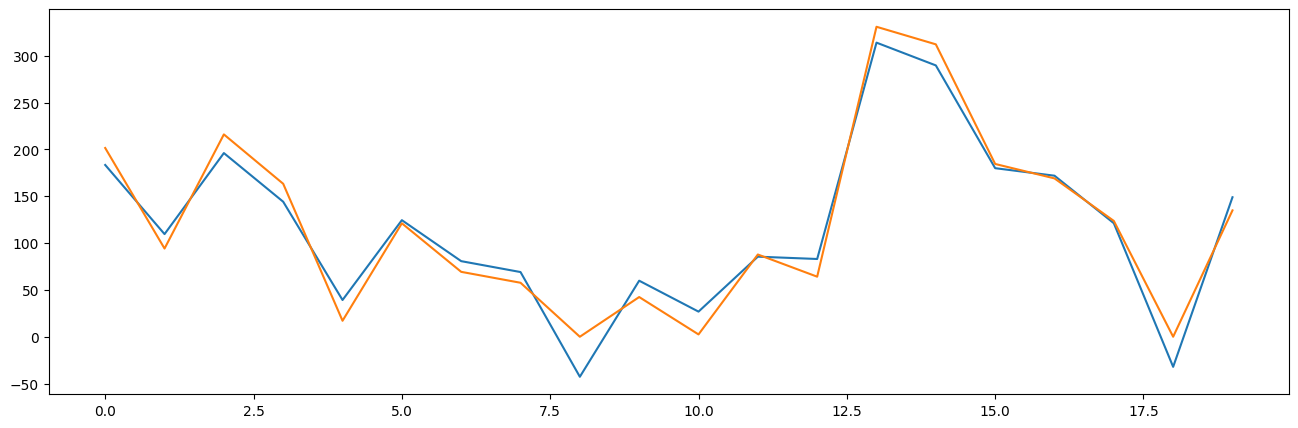

Well num: 4


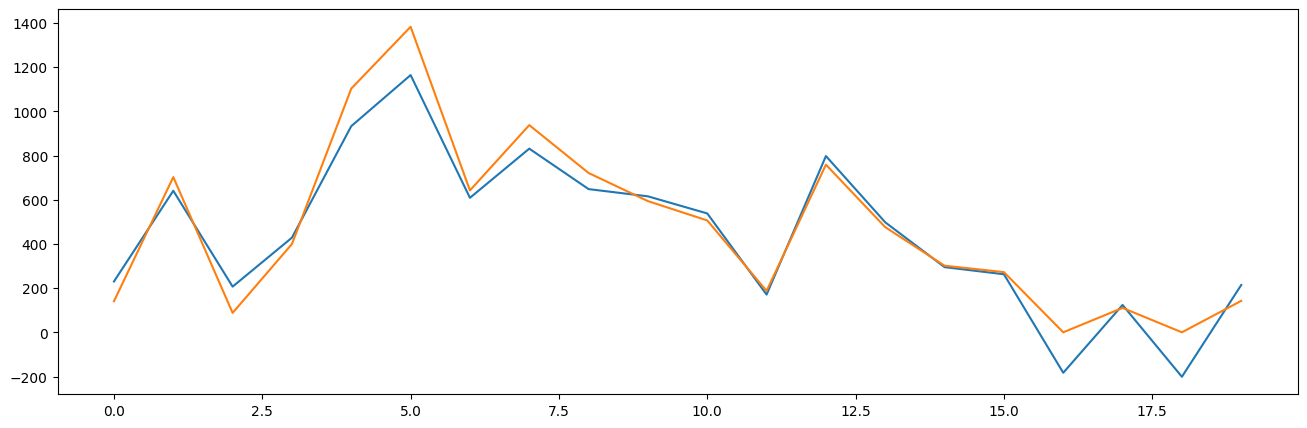

Well num: 5


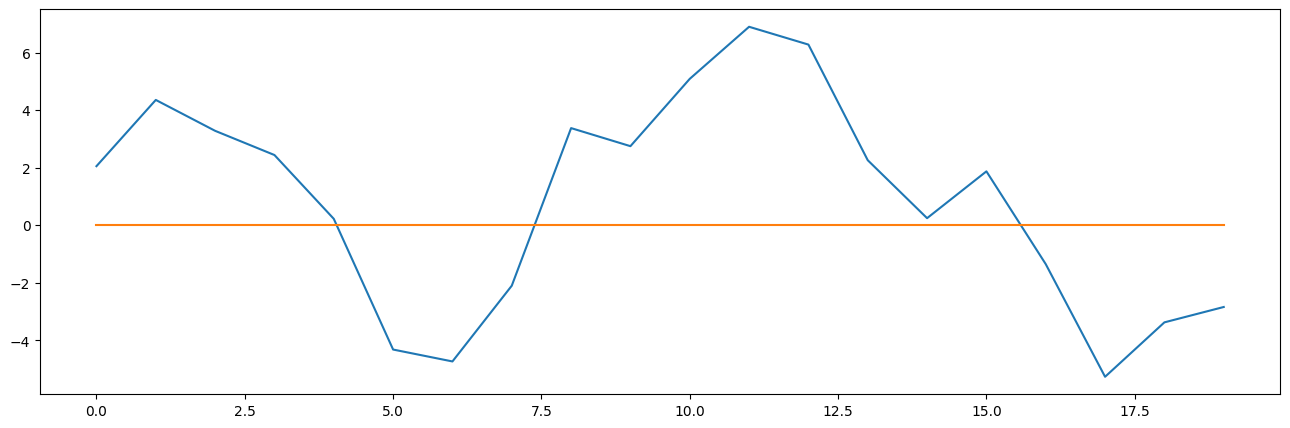

Well num: 6


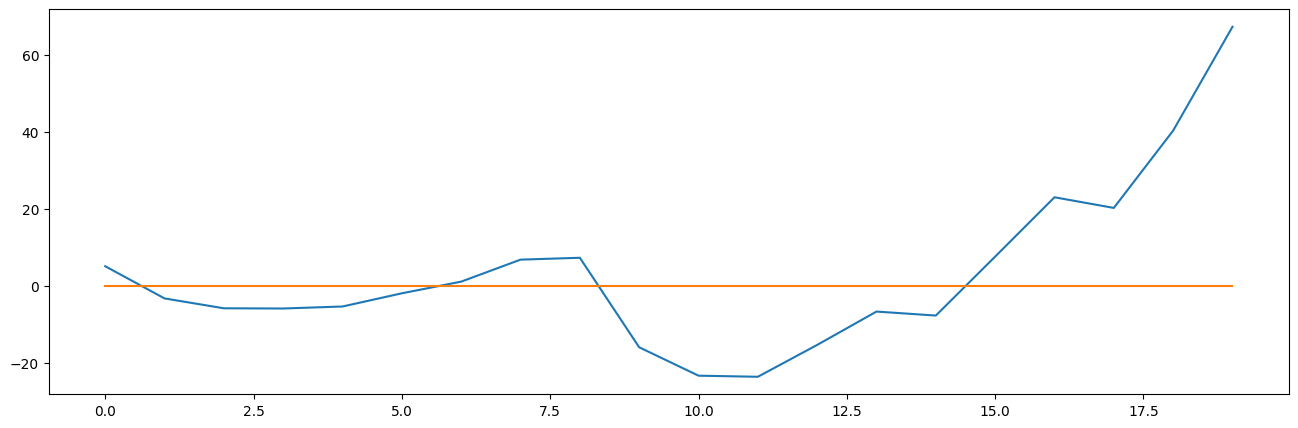

Well num: 7


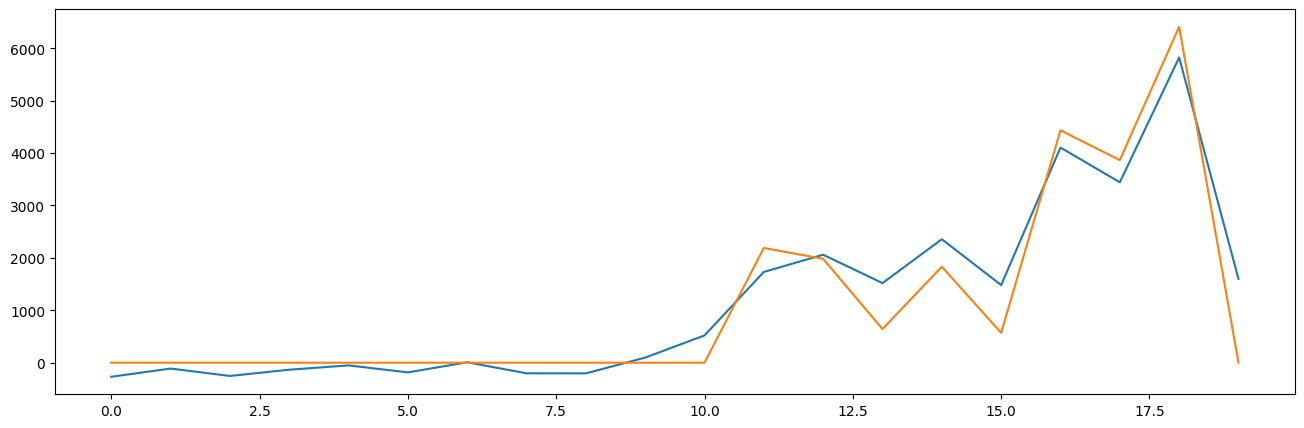

Well num: 8


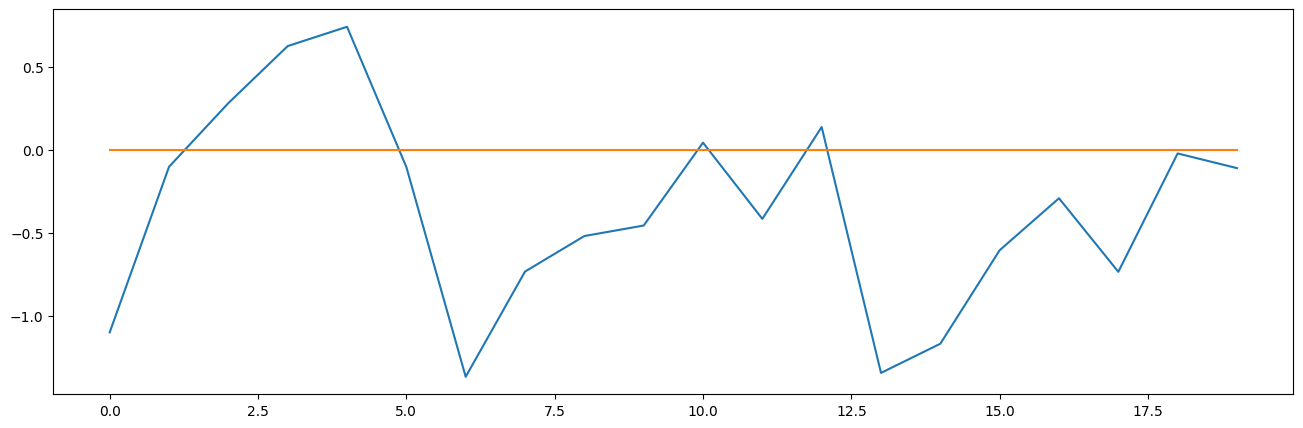

Well num: 9


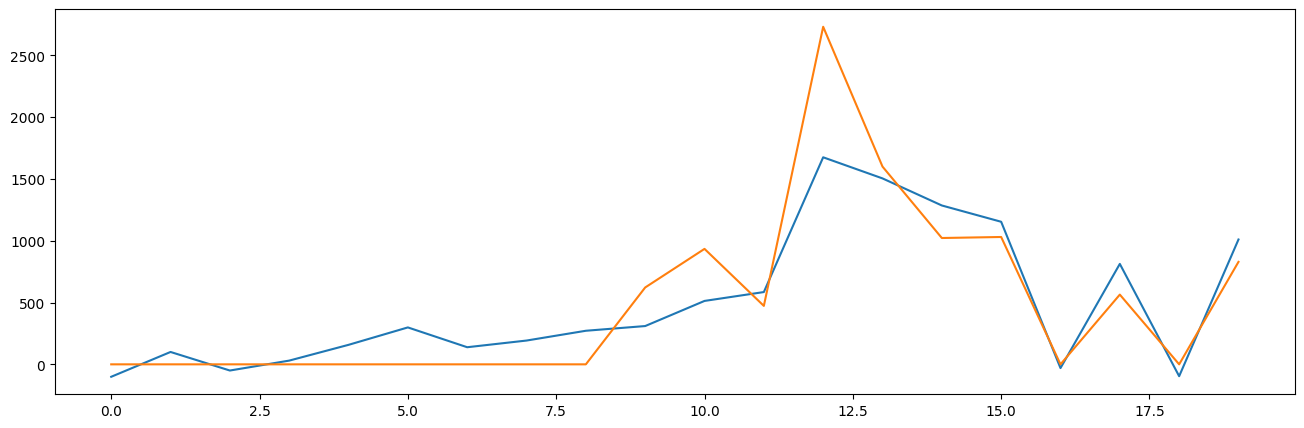

Well num: 10


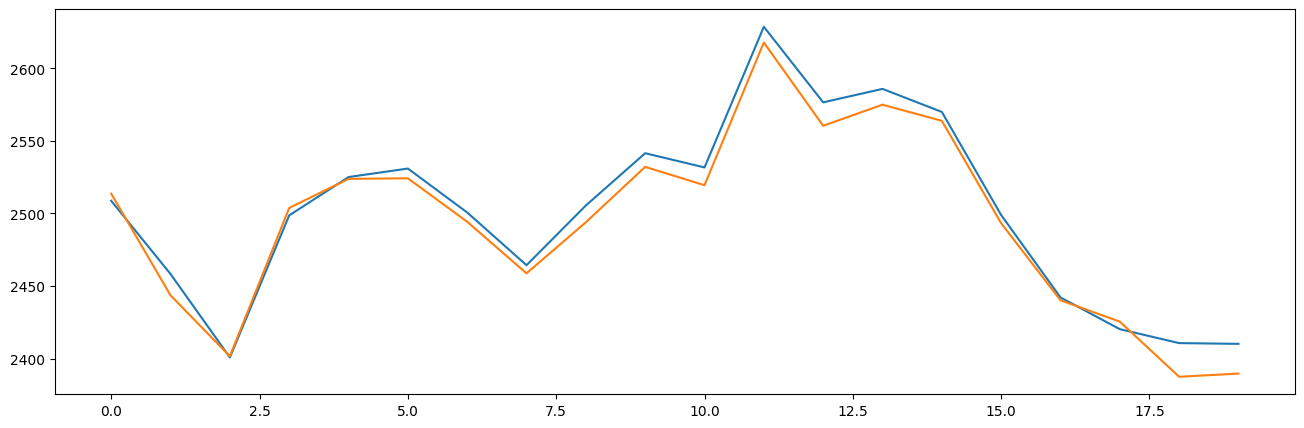

Well num: 11


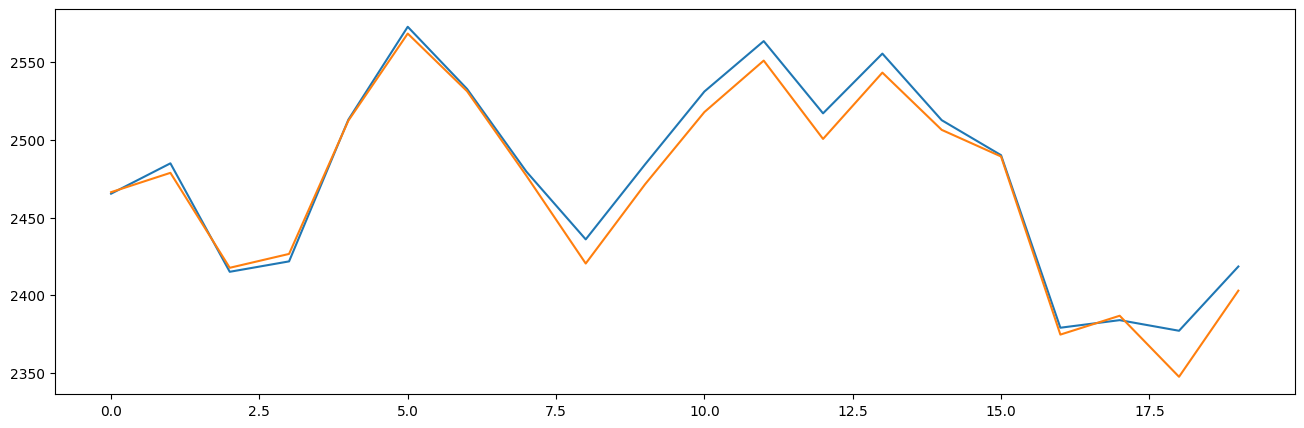

Well num: 12


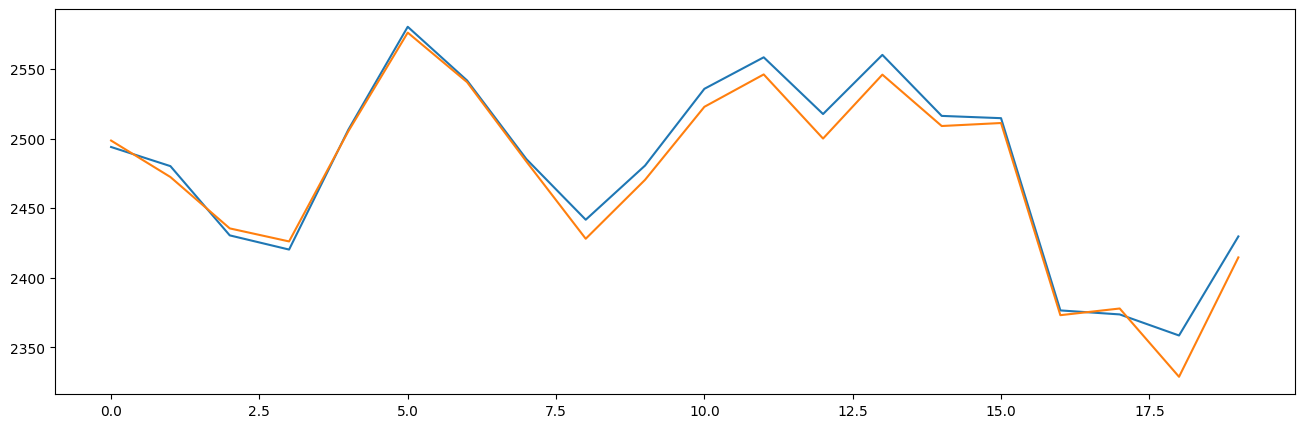

Well num: 13


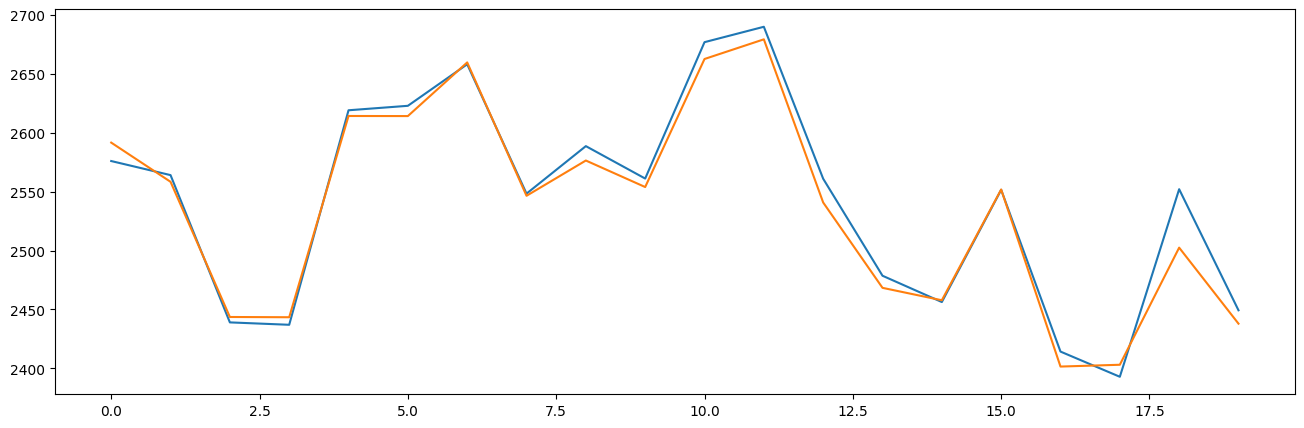

In [55]:
for i_well in range(yobs_pred.shape[-1]):
    print("Well num: %d"%i_well)
    plt.figure(figsize=(16,5))
    # for i_tstep in range(len(t_steps)//divide):
    # plt.subplot(3, num_tstep//divide, i_tstep+1)
    plt.plot(yobs_pred[77, :, i_well].cpu().detach().numpy())

    # plt.hold(True)
    plt.plot(yobs_seq_true[77, :, i_well])
    # plt.xticks([])
    # plt.yticks([])
    # plt.clim([0.1, 0.7])    

    plt.show()
